## k-vs-(N-k) Flu ABM Env
- k-vs-(N-k) experiment
- Kicking tires on multiplayer instance of Flu ABM with RL learners 
- Basic indepRL

In [1]:
import itertools, importlib, sys, warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
# warnings.filterwarnings("ignore")

log_path = './log/flu'
#tensorboard --logdir=flugame_worker_1:'./log/train_rf_flugame_worker'

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')

import embodied_indep as emi 
import flumodel_python.flu_env as Fenv
from embodied_misc import ActionPolicyNetwork, SensoriumNetworkTemplate, ValueNetwork

## Env Setup

In [3]:
# exos = [1,2,3,10]  # (np.random.sample(9223) < 0.3)
exos = (np.random.sample(9223) < 0.002)
exos = [j for j in range(len(exos)) if exos[j]==True]
print(len(exos))

importlib.reload(Fenv);
importlib.reload(emi);
emi._ent_decay_ = 0.5

22


In [4]:
tf.reset_default_graph()
flu_menv = Fenv.Flu_env(
    exo_idx=exos,
    model_path="./flumodel_python/"
)

In [5]:
print(flu_menv.actor_count)
print(flu_menv.state_space_size, flu_menv.action_space_size)

22
8 1


### MARL Setup Demo

In [6]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(32,), gamma_reg=5e-1)
value = lambda s: ValueNetwork(s, hSeq=(16,8,), gamma_reg=1.5)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, 
                                                      hSeq=(16,16,), 
                                                      out_dim=out_dim, gamma_reg=5.)

# num_episodes, n_epochs, max_len = (100, 1501, 25)
# num_episodes, max_len, n_epochs, evry = (100, 35, 501, 100)
# num_episodes, max_len, n_epochs, evry = (25, 10, 121, 40)
num_episodes, max_len, n_epochs, evry = (100, 35, 451, 50)

In [7]:
flumrf = emi.EmbodiedAgent_IRFB(
    name="flu_mRFB", env_=flu_menv,
    alpha_p=40., alpha_v=10.,
    max_episode_length=max_len, _every_=evry,
    actorNN=actor, valueNN=value,
    latentDim=12, sensorium=sensor
)
(flumrf.a_size, flumrf.env.action_space_size)

(1, 1)

In [8]:
sess = tf.InteractiveSession()
flumrf.init_graph(sess) # note tboard log dir
saver = tf.train.Saver(max_to_keep=1) 

Tensorboard logs in:  ./log/train_flu_mRFB_3294


## Baseline

### Baseline for RL/Adaptive Behavioral Model

In [9]:
print('Baselining untrained pnet...')
rwds0 = []
acts_cov = np.zeros([flumrf.actor_count,flumrf.actor_count])
for k in range(num_episodes):
    flumrf.play(sess, terminal_reward=0.);
    rwds0.append(flumrf.last_total_returns)
    actions = np.array(flumrf.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute average rewards
base_perf = 100.*np.mean(np.array(rwds0)/float(flumrf.max_episode_length))
base_per_agent = 100.*np.mean(np.array(rwds0)/float(flumrf.max_episode_length), axis=0)

print("\nAgent is flu-free for an average of {}pct of seasons".format(
    1.*base_perf))

Baselining untrained pnet...
Episode 99/100
Agent is flu-free for an average of 94.12857142857143pct of seasons


Agent Action Correlations:


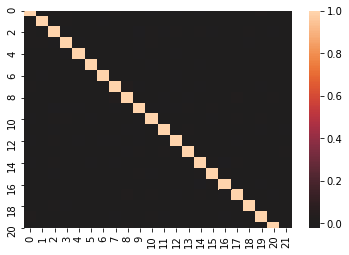

In [10]:
acts_corr = acts_cov.copy()
jm, km = acts_corr.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_corr[j,j])*(acts_corr[k,k]))
        acts_corr[j,k] = acts_corr[j,k]/denom

print("Agent Action Correlations:")
sns.heatmap(acts_corr, center=0)

## Train Agent Population

In [11]:
# ### Train Agents
print('Training...')
hist = flumrf.work(sess, num_epochs=n_epochs, saver=saver)
hist

Training...
Starting agent flu_mRFB_3294
Epoch no.: 0/451

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (28.0, 33.18181818181818, 35.0)
Losses/Policy LLs: (-2.343606, -0.56199485, -0.10090479)
Losses/Critic Scores: (-1.1234001, 0.81743735, 2.3145952)
Losses/Policy Entropies: (0.31616122, 0.5614717, 0.6931431)
Saved Model
Epoch no.: 50/451

	Stats @Step 50: 	(Min, Mean, Max)
Perf/Recent Rewards: (26.0, 32.68181818181818, 35.0)
Losses/Policy LLs: (-5.0019765, -0.18454546, -2.5067109e-06)
Losses/Critic Scores: (11.532212, 15.02778, 18.178913)
Losses/Policy Entropies: (0.01, 0.18479714, 0.6753168)
Saved Model
Epoch no.: 100/451

	Stats @Step 100: 	(Min, Mean, Max)
Perf/Recent Rewards: (28.0, 32.95454545454545, 35.0)
Losses/Policy LLs: (-2.3291228, -0.22798811, -8.983846e-06)
Losses/Critic Scores: (12.485573, 14.895584, 16.762302)
Losses/Policy Entropies: (0.01, 0.24501193, 0.69248855)
Saved Model
Epoch no.: 150/451

	Stats @Step 150: 	(Min, Mean, Max)
Perf/Recent Rewards: (27.0, 

array([[28.        , 33.18181818, 35.        ],
       [28.        , 32.86363636, 35.        ],
       [28.        , 33.04545455, 35.        ],
       ...,
       [25.        , 32.90909091, 35.        ],
       [26.        , 33.22727273, 35.        ],
       [29.        , 33.31818182, 35.        ]])

## Test

In [12]:
# Test pnet!
print('Testing...')
rwds = []
acts_cov_trained = np.zeros([flumrf.actor_count,flumrf.actor_count])
for k in range(num_episodes):
    flumrf.play(sess)
    rwds.append(flumrf.last_total_returns)
    actions = np.array(flumrf.episode_buffer['actions']).T
    acts_cov_trained = acts_cov_trained + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

trained_perf = 100.*np.mean(np.array(rwds)/float(flumrf.max_episode_length))
trained_per_agent = 100.*np.mean(np.array(rwds)/float(flumrf.max_episode_length), axis=0)

print("\nAgent is flu-free for an average of {} pct compared to baseline of {} pct".format(
    1.*trained_perf, 1.*base_perf) )

Testing...
Episode 99/100
Agent is flu-free for an average of 94.73896103896104 pct compared to baseline of 94.12857142857143 pct


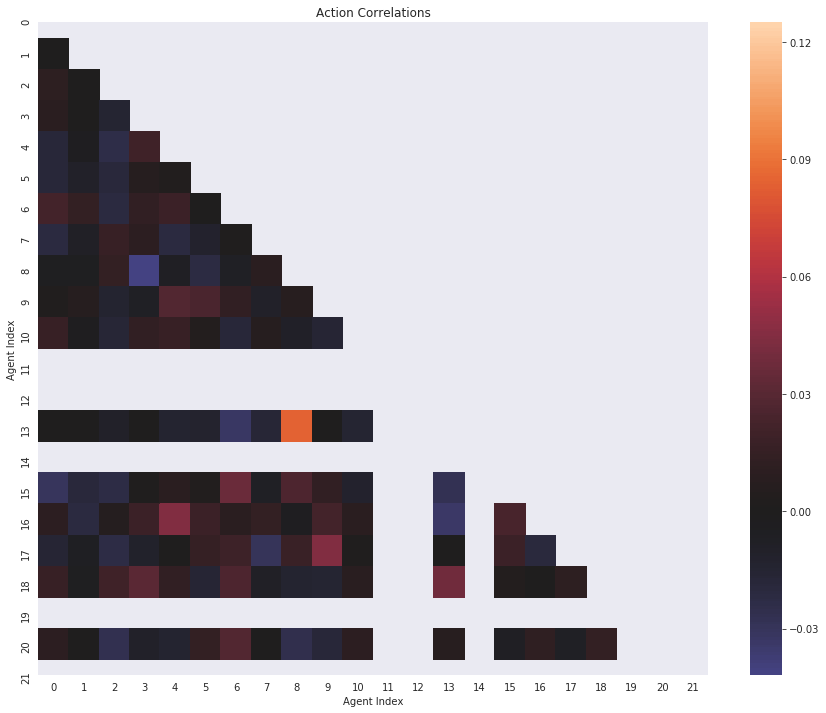

In [13]:
acts_corr_trained = acts_cov_trained.copy()
jm, km = acts_corr_trained.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_cov_trained[j,j])*(acts_cov_trained[k,k]))
        acts_corr_trained[j,k] = acts_corr_trained[j,k]/denom

mask = np.zeros_like(acts_corr_trained)
mask[np.triu_indices_from(mask,k=0)] = True
with sns.axes_style("darkgrid"):
    plt.rcParams['figure.figsize'] = (15, 12)
    ax = sns.heatmap(acts_corr_trained, 
                     mask=mask, vmax=0.125, center=0)
    ax.set_ylabel("Agent Index")
    ax.set_xlabel("Agent Index")
    ax.set_title("Action Correlations")

## Evaluate

In [14]:
rwds0_df = pd.DataFrame(100.*(np.array(rwds0)/float(flumrf.max_episode_length)))
rwds_df = pd.DataFrame(100.*(np.array(rwds)/float(flumrf.max_episode_length)))

rwds0_df['Wave'] = "Baseline"
rwds_df['Wave'] = "Trained"

resDF = pd.concat([rwds0_df, rwds_df])
resDF.columns = ["Agent"+str(tc) if tc is not "Wave" else tc for tc in resDF.columns]
# resDF['id'] = resDF.index
print(resDF.shape)
# resDF.head()


(200, 23)


In [15]:
resDF = resDF.melt(
    id_vars=['Wave'], #['id', 'Wave'],
    value_vars=[tc for tc in resDF.columns if "Agent" in tc]
)
resDF = resDF.rename(columns={"variable": "Agent", "value": "Immune_pct"})
print(resDF.shape)

res_tabs = resDF.groupby(['Agent','Wave']).aggregate(['mean','std']) # res_tabs

# resDF.head()

(4400, 3)


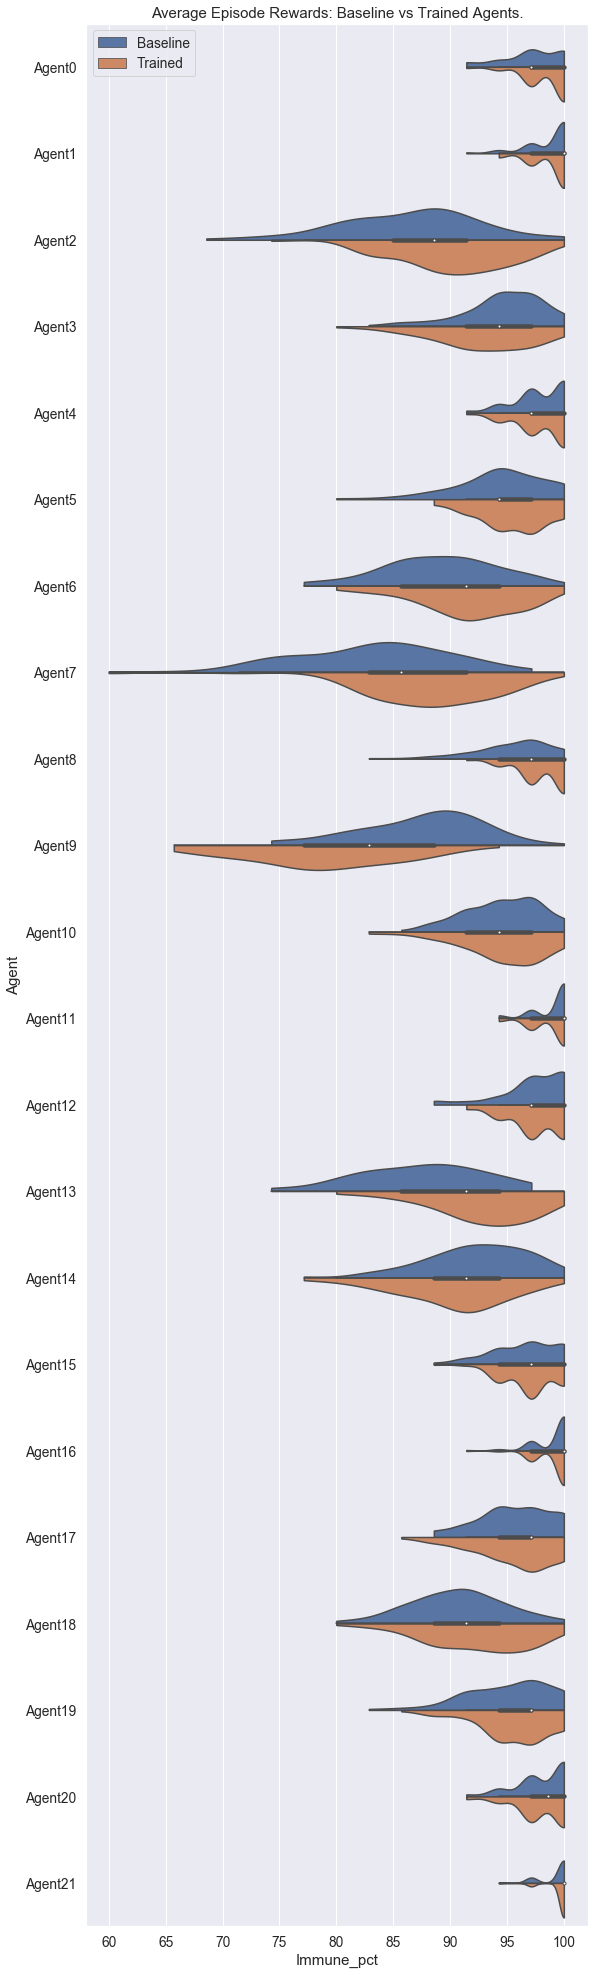

In [16]:
plt.rcParams['figure.figsize'] = (9, 35)
sns.set(font_scale=1.25)

fig = sns.violinplot(data=resDF, inner="box", cut=0,
                     x="Immune_pct", y="Agent", hue="Wave",
                     split=True);
fig.set_title(
    'Average Episode Rewards: Baseline vs Trained Agents.');
fig.legend(loc='upper left');

In [17]:
base_meanDF = resDF[resDF.Wave=="Baseline"].groupby(['Agent']).aggregate(['mean'])
base_meanDF.sort_index(inplace=True)

trained_meanDF = resDF[resDF.Wave=="Trained"].groupby(['Agent']).aggregate(['mean'])
trained_meanDF.sort_index(inplace=True)

mean_diffDF = (trained_meanDF - base_meanDF)
mean_diffDF.columns = ['Mean_Immune_Pct_Change']
# mean_diffDF.head()

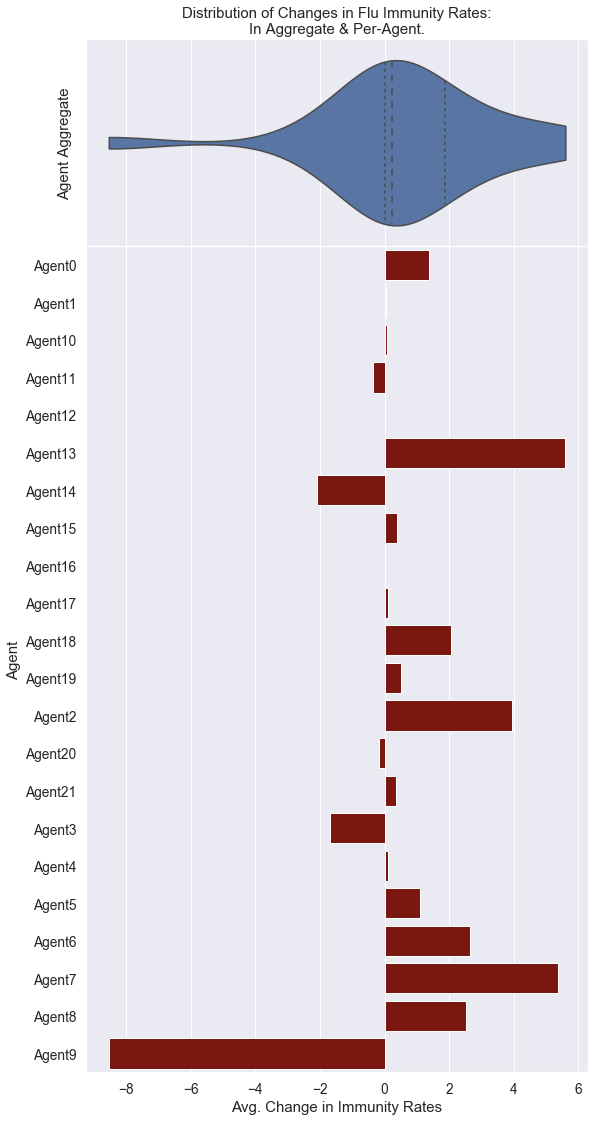

In [18]:
plt.rcParams['figure.figsize'] = (9, 19)
sns.set_color_codes("dark")
fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [1,4]})
cmp = sns.violinplot(x='Mean_Immune_Pct_Change', cut=0, inner='quartile',
                     data=mean_diffDF, ax=axs[0])
axs[0].set_ylabel('Agent Aggregate');
axs[0].set_title(
    'Distribution of Changes in Flu Immunity Rates:\nIn Aggregate & Per-Agent.'
);

sns.barplot(y=mean_diffDF.index, x="Mean_Immune_Pct_Change", 
            data=mean_diffDF, color="r",
            label="Success Rate", ax=axs[1]);
plt.subplots_adjust(wspace=0, hspace=0)
axs[1].set_xlabel('Avg. Change in Immunity Rates');

### Baseline for Default Behavioral Model

In [19]:
import flumodel_python.flu_env_basic as FABM
# ?Fenv.Flu_ABM
importlib.reload(FABM);
flu = FABM.Flu_ABM(model_path="./flumodel_python/")

# Burn-in Flu ABM First...
for _ in range(30):
    _ = flu.stepAll()

In [ ]:
flu_hist = np.zeros([num_episodes, len(exos)])
for k in range(num_episodes):
    tmp = np.zeros(len(exos))
    for _ in range(max_len):
        tmp += (1.-np.array(flu.stepAll(), dtype=float))[exos]
    flu_hist[k,:] = tmp

In [ ]:
rwds_dbm = 100.*flu_hist/float(max_len)
print(len(exos), rwds_dbm.shape, 
      np.mean(rwds_dbm, axis=0).shape)

In [ ]:
print(np.mean(rwds_dbm),
      np.mean(rwds_dbm, axis=0)
     )

In [ ]:
plt.rcParams['figure.figsize'] = (8,3)
sns.boxplot(np.mean(rwds_dbm, axis=0) - base_per_agent)

### Compare to Default Behavioral Model

In [ ]:
trcmp = 100.*(np.array(rwds)/float(flumrf.max_episode_length))
cmp = np.mean((trcmp-rwds_dbm), axis=0)
sns.boxplot(cmp)

In [ ]:
plt.rcParams['figure.figsize'] = (8,3)

np.mean(trcmp - np.mean(rwds_dbm, axis=0))